### The purpose of nba-api is to scrape basketball-reference.com and extract matchup information and team statistics
Jake Giguere giguere@bu.edu

disclaimer: This is software is soley for educational purposes. Please do not use this for gambling or sport-betting.

In [ ]:
import os

import time
from io import StringIO

import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import tensorflow as tf



print("TensorFlow version:", tf.__version__)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Start by extracting the matchups for every year from 2022-2024 in months Oct-Apr and concatenate them to a dataframe. We need the Home team, Pts, Visitor Team, Pts
url: https://www.basketball-reference.com/leagues/NBA_2024_games-{month}.html#schedule 

In [7]:
months = ["october", "november", "december", "january", "february", "march", "april"]
data = pd.DataFrame()
for year in range(2022,2025):
    for month in months:
        url = f"https://www.basketball-reference.com/leagues/NBA_{year}_games-{month}.html#schedule"

        try:
            r = requests.get(url)
            r.raise_for_status()
        except Exception as e:
            print("Could not fetch months {} games")
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table', {'id': 'schedule'})

        if table:
            table = StringIO(str(table))
            month_data = pd.read_html(table)[0]
            data = pd.concat([data, month_data], ignore_index=True) 






### Convert data into a CSV so we can prevent repetitive api calls

In [8]:
data.to_csv('Data/matchups.csv')
data.shape

### 3833 games collected with 12 rows however we only need the 4 rows mentioned above.

In [ ]:
features = ['Visitor/Neutral', 'PTS', 'Home/Neutral', 'PTS.1']

data = data[features]
data.head()

### Now lets collect team statistics using game log. We should also grab all the team abreviations using ChatGPT to save time
url: https://www.basketball-reference.com/teams/{team_abrv}/{year}/gamelog/


In [55]:
# Dictionary mapping team names to their abbreviations
TEAM_MAP = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}

# Create a reverse dictionary for abbreviation to full team name
ABBR_MAP = {abbr: team for team, abbr in TEAM_MAP.items()}

def get_team_name_or_abbr(input_str):
    """Convert a team name to its abbreviation or vice versa."""
    input_str = input_str.strip()
    
    # Check if the input is an abbreviation
    if input_str.upper() in ABBR_MAP:
        return ABBR_MAP[input_str.upper()]
    # Check if the input is a full team name
    elif input_str.title() in TEAM_MAP:
        return TEAM_MAP[input_str.title()]
    else:
        return "Team not found."

# Example Usage
print(get_team_name_or_abbr("Boston Celtics"))  # Output: "BOS"
print(get_team_name_or_abbr("LAL"))             # Output: "Los Angeles Lakers"
print(get_team_name_or_abbr("NYK"))             # Output: "New York Knicks"
print(get_team_name_or_abbr("Toronto Raptors")) # Output: "TOR"


BOS
Los Angeles Lakers
New York Knicks
TOR


In [56]:
abv = list(TEAM_MAP.values())
abv

['ATL',
 'BOS',
 'BRK',
 'CHO',
 'CHI',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHO',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS']

In [ ]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}
abreviations = list(TEAM_MAP.values()) #list of all abreviations
years = range(2022, 2025)
teams_data = pd.DataFrame()
for year in years:
    for abrv in abreviations:
        url = f'https://www.basketball-reference.com/teams/{abrv}/{year}/gamelog/'

        try:
            r = requests.get(url, headers=headers)
            r.raise_for_status()
        except Exception as e:
            print(f'Could not fetch {abrv}/{year}')
            r.raise_for_status()
        
        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table', {'id': 'tgl_basic'})


        if table:
            table = StringIO(str(table))
            team = pd.read_html(table)[0]
            team['tm'] = abrv
            teams_data = pd.concat([teams_data, team], ignore_index=True)

    time.sleep(120)




In [ ]:
teams_data.shape

### Save/Overwrite to gamelog csv file should have 2700x3 years about +8000 rows 

In [53]:
teams_data.to_csv('Data/gamelogs2022_2024.csv', mode='a', header=not pd.io.common.file_exists('Data/gamelogds2022_2024.csv'), index=False)

NameError: name 'teams_data' is not defined

Clean up the game log. repeated headers, etc. save to Data/cleaned_gamelogs.csv


In [ ]:
data = pd.read_csv('Data/gamelogs2022_2024.csv', header=1)

#Remove any multi labeled rows, and unnamed values 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data[data['Rk'].apply(lambda x: str(x).isdigit())]

data.reset_index(drop=True, inplace=True)
# Display the first few rows of the cleaned DataFrame
data.to_csv('Data/cleaned_gamelogs.csv', index=False)


time to prepare the data for the Sequential Model

In [108]:
cleaned_df = pd.read_csv('Data/cleaned_gamelogs.csv')
print(cleaned_df.columns)

# Load the cleaned dataset
data = pd.read_csv('Data/cleaned_gamelogs.csv')
feature_columns = ['Pts.1', 
                'FG%', 'FG%.1',
                'FGA', 'FGA.1',
                '3P%', '3P%.1',
                '3PA', '3PA.1',
                'ORB', 'ORB.1',
                'TRB', 'TRB.1',
                'AST', 'AST.1',
                'TOV', 'TOV.1',
                'STL', 'STL.1',
                'PF', 'PF.1']
# Define features (excluding 'Tm' which is the target)
features = data[feature_columns]
target = data['Pts']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Scale the features for better performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

print(X_train[1:5])



Index(['Rk', 'G', 'Date', 'Opp', 'W/L', 'Pts', 'Pts.1', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1',
       'FT.1', 'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1',
       'TOV.1', 'PF.1', 'tm'],
      dtype='object')
(5904, 21)
(1476, 21)
[[ 0.45822791  2.49105207  1.10366532  0.50794285  0.77873755  2.10003712
  -0.46698428  1.20678896 -1.46346385 -0.62827103  0.65251779 -1.17875504
  -0.87602353  1.65691835  0.87965432 -0.99775566  0.31257297  0.54943715
  -0.51488635 -0.59312066 -0.10949894]
 [-2.29802218  1.04428969 -1.19285436 -0.48464603 -0.63518947  0.42346539
  -1.99707896  0.46158636 -1.31490825  0.40417269  0.65251779  0.02554862
  -0.57607323  0.0827226  -1.08022307 -0.99775566  1.35577863  1.60595988
  -1.91980327 -1.31757781  0.13593832]
 [ 0.85197792 -2.22901017  0.79625718  0.08254762  1.20291566 -1.09742467
  -0.63433839  0.9087

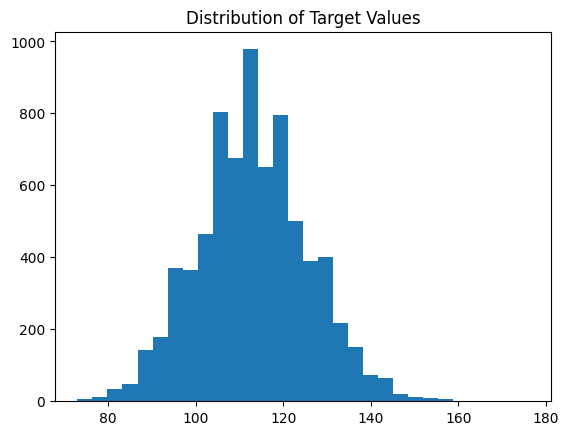

Target Value Stats:
count    7380.000000
mean      113.171003
std        12.613352
min        73.000000
25%       105.000000
50%       113.000000
75%       122.000000
max       176.000000
Name: Pts, dtype: float64


In [83]:
import matplotlib.pyplot as plt

plt.hist(target, bins=30)
plt.title("Distribution of Target Values")
plt.show()

print("Target Value Stats:")
print(target.describe())


Check for NaNs or Infinite Values

In [16]:
import numpy as np

Build the MLP with tensorflow

In [84]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from keras import layers

In [85]:
model = Sequential(
    [
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Output layer for regression
    ]
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)


Epoch 1/300


/Users/jakegiguere/Boston University/Fall24/CS767/Assignment2 /plonn-nba/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12652.5791 - mae: 111.7404 - val_loss: 9112.5098 - val_mae: 94.4673
Epoch 2/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5923.6743 - mae: 72.1842 - val_loss: 642.0652 - val_mae: 20.2221
Epoch 3/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 575.1074 - mae: 19.2297 - val_loss: 523.1764 - val_mae: 18.2471
Epoch 4/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 474.0720 - mae: 17.4930 - val_loss: 447.9299 - val_mae: 16.9057
Epoch 5/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 388.0168 - mae: 15.8339 - val_loss: 389.8797 - val_mae: 15.7717
Epoch 6/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 335.9188 - mae: 14.7237 - val_loss: 338.7512 - val_mae: 14.6839
Epoch 7/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 293.7214 - mae: 13.6220 - val_loss: 291.8506 - val_mae: 13.5767
Epoch 8/300
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 249.6284 - mae: 12.6244 - val_loss: 252.3860 - val_mae: 12.6791
Epoch 9

Save the model

In [116]:
# Save the trained model right after training
model.save('nba_model.keras')
print("Model saved as 'nba_model.h5'")

Model saved as 'nba_model.h5'


Evaluate model

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error: 2.92
Root Mean Squared Error: 3.65


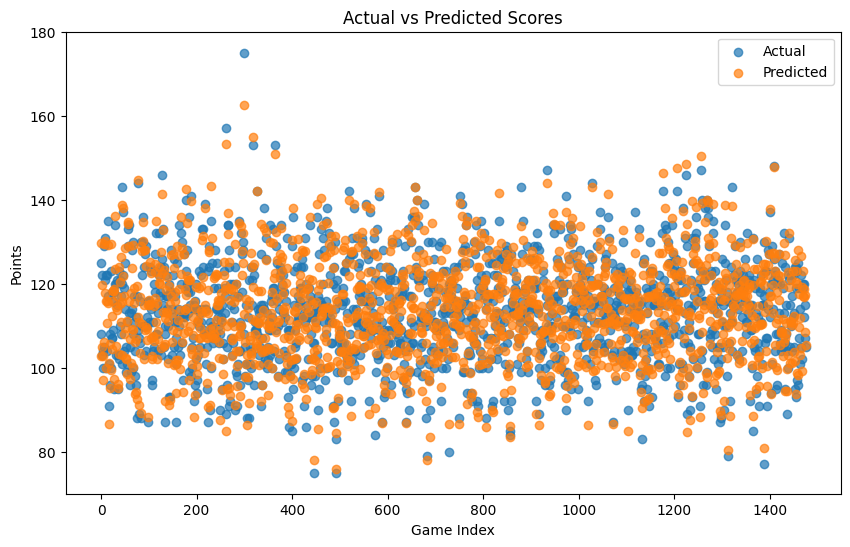

In [90]:
import matplotlib.pyplot as plt

# Assuming `y_test` is the actual values and `predictions` are your model's predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Game Index')
plt.ylabel('Points')
plt.title('Actual vs Predicted Scores')
plt.legend()
plt.show()

In [96]:
# Step 1: Scrape today's games
from datetime import datetime

def get_today_games():
    # Define the URL for the November 2024 NBA schedule
    url = "https://www.basketball-reference.com/leagues/NBA_2025_games-november.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the schedule table
    schedule_table = soup.find('table', {'id': 'schedule'})
    if not schedule_table:
        print("Schedule table not found.")
        return pd.DataFrame()
    
    # Extract rows from the table
    rows = schedule_table.find_all('tr')
    
    # Get today's date in the format used on the website
    today = datetime.now().strftime('%a, %b %d, %Y')
    
    # Initialize a list to hold today's games
    games_today = []
    
    for row in rows:
        # Extract the date cell
        date_cell = row.find('th', {'data-stat': 'date_game'})
        if date_cell and date_cell.text.strip() == today:
            # Extract team names
            away_team = row.find('td', {'data-stat': 'visitor_team_name'}).text.strip()
            home_team = row.find('td', {'data-stat': 'home_team_name'}).text.strip()
            games_today.append({'home_team': home_team, 'away_team': away_team})
    
    # Convert the list to a DataFrame
    return pd.DataFrame(games_today)

# Fetch today's games
today_games = get_today_games()
print("Today's Matchups:")
print(today_games)


Today's Matchups:
                home_team               away_team
0          Boston Celtics           Atlanta Hawks
1         Detroit Pistons              Miami Heat
2           Orlando Magic       Charlotte Hornets
3      Philadelphia 76ers         New York Knicks
4         Milwaukee Bucks         Toronto Raptors
5               Utah Jazz            Phoenix Suns
6   Golden State Warriors        Dallas Mavericks
7  Portland Trail Blazers  Minnesota Timberwolves


Get team current team per game data

In [125]:
def get_team_per_game_stats(team_abbr):
    """
    Scrapes the 'per_game' table for a given team using its abbreviation.
    """
    url = f"https://www.basketball-reference.com/teams/{team_abbr}/2025.html"
            
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the per-game table
    per_game_table = soup.find('table', {'id': 'per_game_stats'})
    if not per_game_table:
        print(f"Per-game table not found for {team_abbr}.")
        return {}
    if per_game_table:
        table = StringIO(str(per_game_table))
        df = pd.read_html(table)[0]
        
        # Read the table using pandas
    
    
        # Extract the row corresponding to 'Team Totals'
        team_totals_row = df[df['Player'] == 'Team Totals']
        if team_totals_row.empty:
            print(f"No 'Team Totals' row found for {team_abbr}.")
            return {}

        # Convert the row to a dictionary
        team_stats = team_totals_row.iloc[0].to_dict()

        # Extract only the required columns
        feature_columns = ['Pts', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 
                           'AST', 'TOV', 'STL', 'PF']

        # Map to desired format
        relevant_stats = {col: team_stats.get(col, 0) for col in feature_columns}

        return relevant_stats
    
        
    
bos = get_team_name_or_abbr(today_games.iloc[0][0])
atl = get_team_name_or_abbr(today_games.iloc[0][1])


bos = get_team_per_game_stats(bos)
atl = get_team_per_game_stats(atl)

print(bos, atl)


/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_87647/1257809606.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bos = get_team_name_or_abbr(today_games.iloc[0][0])
/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_87647/1257809606.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atl = get_team_name_or_abbr(today_games.iloc[0][1])


{'Pts': 0, 'FG%': 0.45, 'FGA': 91.3, '3P%': 0.362, '3PA': 51.3, 'ORB': 10.3, 'TRB': 43.5, 'AST': 23.9, 'TOV': 11.9, 'STL': 7.9, 'PF': 16.4} {'Pts': 0, 'FG%': 0.464, 'FGA': 89.4, '3P%': 0.351, '3PA': 36.0, 'ORB': 11.0, 'TRB': 42.5, 'AST': 28.0, 'TOV': 15.6, 'STL': 10.1, 'PF': 19.8}


Create a match up vector for both teams to follow the model features 

In [126]:
def create_matchup_feature_vector(home_team, away_team, team_abbreviation_func):
    """
    For a given matchup, fetch stats for the home and away teams,
    and create a combined feature vector.
    """
    home_abbr = team_abbreviation_func(home_team)
    away_abbr = team_abbreviation_func(away_team)
    
    # Get stats for both teams
    home_stats = get_team_per_game_stats(home_abbr)
    away_stats = get_team_per_game_stats(away_abbr)
    
    # Rename away team columns with '.1' suffix
    away_stats = {f"{key}.1": value for key, value in away_stats.items()}
    
    # Combine home and away team stats
    combined_stats = {**home_stats, **away_stats}
    
    return combined_stats

### Get Data for todays games teams

In [142]:
today_games = pd.DataFrame({
    'home_team': ['Atlanta Hawks', 'Miami Heat',  'Utah Jazz', 'Golden State Warriors', 'Minnesota Timberwolves'],
    'away_team': ['Boston Celtics', 'Detroit Pistons', 'Phoenix Suns', 'Dallas Mavericks', 'Portland Trail Blazers']
})

# Generate feature vectors for today's matchups
feature_vectors = []
for _, game in today_games.iterrows():
    features = create_matchup_feature_vector(
        game['home_team'], game['away_team'], get_team_name_or_abbr
    )
    feature_vectors.append(features)

# Convert to a DataFrame for easy viewing
feature_df = pd.DataFrame(feature_vectors)
print("Feature Vectors for Today's Matchups:")
print(feature_df.columns)


# Filter the DataFrame to include only the columns your model expects
feature_df = feature_df[feature_columns]

# Check the shape to ensure it's correct
print("Adjusted Feature Vectors:")
print(feature_df)
print("Shape of feature_df:", feature_df.shape)

Feature Vectors for Today's Matchups:
Index(['Pts', 'FG%', 'FGA', '3P%', '3PA', 'ORB', 'TRB', 'AST', 'TOV', 'STL',
       'PF', 'Pts.1', 'FG%.1', 'FGA.1', '3P%.1', '3PA.1', 'ORB.1', 'TRB.1',
       'AST.1', 'TOV.1', 'STL.1', 'PF.1'],
      dtype='object')
Adjusted Feature Vectors:
   Pts.1    FG%  FG%.1   FGA  FGA.1    3P%  3P%.1   3PA  3PA.1   ORB  ...  \
0      0  0.464  0.450  89.4   91.3  0.351  0.362  36.0   51.3  11.0  ...   
1      0  0.441  0.465  87.4   85.8  0.390  0.339  37.3   34.6  10.7  ...   
2      0  0.420  0.470  85.0   85.9  0.316  0.374  37.2   41.2  11.9  ...   
3      0  0.478  0.473  92.4   90.5  0.395  0.348  41.3   36.5  13.6  ...   
4      0  0.478  0.426  85.3   91.4  0.393  0.302  41.7   33.4   9.7  ...   

    TRB  TRB.1   AST  AST.1   TOV  TOV.1   STL  STL.1    PF  PF.1  
0  42.5   43.5  28.0   23.9  15.6   11.9  10.1    7.9  19.8  16.4  
1  43.0   45.8  25.4   23.9  13.2   17.3   9.4    5.2  17.4  20.9  
2  45.7   44.5  23.6   27.4  19.3   13.8   7.0    7

Load out model 'nba_model.keras'

In [141]:
loaded_model = tf.keras.models.load_model('nba_model.keras')

# Example: Make predictions using the loaded model

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

# Make predictions using the loaded model
predicted_scores = model.predict(scaled_features)

# Add the predicted scores to the original DataFrame
today_games['predicted_scores'] = predicted_scores.flatten()

# Display the results
print("\nPredicted Scores for Today's Matchups:")
print(today_games)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Predicted Scores for Today's Matchups:
                home_team               away_team  predicted_scores
0           Atlanta Hawks          Boston Celtics        107.805176
1              Miami Heat         Detroit Pistons        104.592804
2               Utah Jazz            Phoenix Suns         82.988205
3   Golden State Warriors        Dallas Mavericks        136.437790
4  Minnesota Timberwolves  Portland Trail Blazers        131.431290


/Users/jakegiguere/Boston University/Fall24/CS767/Assignment2 /plonn-nba/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
